<a href="https://colab.research.google.com/github/duTianze/machine-learning/blob/master/MRI_autoencoder222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 下载数据

In [1]:
!pip3 install kaggle

In [2]:
!kaggle

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 489, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2793, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2411, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2417, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_d

In [0]:
!echo "{\"username\":\"dutianze\",\"key\":\"ff2944c6219d449b37460827c4414422\"}" > /root/.kaggle/kaggle.json

In [4]:
!more /root/.kaggle/kaggle.json

{"username":"dutianze","key":"ff2944c6219d449b37460827c4414422"}


In [5]:
!kaggle datasets download -d dutianze/mri-dataset

 99% 1.09G/1.10G [00:26<00:00, 42.5MB/s]
100% 1.10G/1.10G [00:26<00:00, 44.1MB/s]


In [6]:
!apt-get install zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
!unzip -q ./mri-dataset.zip

###创建generate

In [0]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def muti(f1, f2):
    return f1*f2
  
def process(np_train, fname, index):
    mark_dir = os.path.join('./train/groundtruth')
    head_mark = 'mask_c'
    sub_name = fname[1:]
    mark = head_mark + sub_name
    
    file_mark = os.path.join(mark_dir, mark)
    data = nib.load(file_mark).get_fdata()
    np_data = np.rollaxis(data, 2, 0)
    
    mp_marked = muti(np_data[index], np_train)
    return mp_marked
  
  
def generate_data(directory, batch_size):
    i = 0
    size = 880
    skip = False
    file_list = os.listdir(directory)
    while True:
        for b in range(batch_size):
            if i == len(file_list):
                i = 0
                random.shuffle(file_list)
            sample = file_list[i]
            i += 1
            
            file_dir = os.path.join(directory, sample)
            data  = nib.load(file_dir).get_fdata()
            np_data = np.rollaxis(data, 2, 0)
                
            train_batch = np.zeros((batch_size*12, np_data.shape[1], np_data.shape[2]), dtype=np.int)
            label_batch = np.zeros((batch_size*12, np_data.shape[1], np_data.shape[2]), dtype=np.int)

            for i in range(12):
                train_batch[i] = np_data[i]
                label_batch[i] = process(np_data[i], sample, i)
        if skip:
            continue
        train_batch = train_batch.reshape((len(train_batch), size, size, 1))
        label_batch = label_batch.reshape((len(label_batch), size, size, 1))
        yield train_batch, label_batch

### 创建模型

In [0]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

In [135]:
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(880, 880, 1)))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 880, 880, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 440, 440, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 440, 440, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 220, 220, 32)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 440, 440, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 440, 440, 32)      9248      
__________

### 训练模型

In [0]:
train_generator = generate_data('./train/image', 1)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

history = autoencoder.fit_generator(train_generator,
steps_per_epoch=20,
epochs=100,
verbose=1)

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/100
20/20 [==============================] - 41s 2s/step - loss: -419.1882
Epoch 2/100
20/20 [==============================] - 39s 2s/step - loss: -465.8162
Epoch 3/100
14/20 [====================>.........] - ETA: 11s - loss: -466.2900

In [0]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
file_list = os.listdir('./train/image')
for i in range(len(file_list)):
  f = os.path.join('./train/image', file_list[66])
  data  = nib.load(f).get_fdata()
  print(data.shape)

In [0]:
file_list = os.listdir('./train/image')
f = os.path.join('./train/image', file_list[66])
data  = nib.load(f).get_fdata()
np_data = np.rollaxis(data, 2, 0)
test = np_data[5]
test2 = test.reshape(-1,880,880,1)

In [0]:
predict = autoencoder.predict(test2)

In [0]:
predict2 = predict.reshape(880,880)

In [160]:
test.shape

(880, 880)

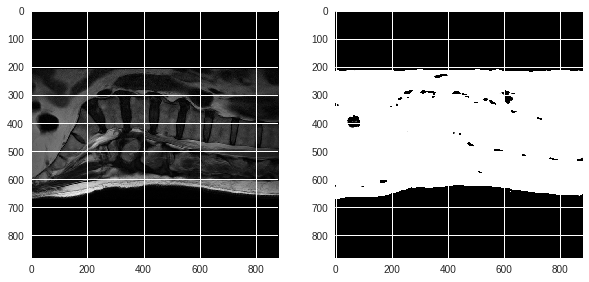

In [161]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plt.imshow(test, cmap='gray')
plt.subplot(222)
plt.imshow(predict2, cmap='gray')